# Analysis

![IP Rep1 Signal](images/IP_rep1_signal_coverage.png)

The plot above shows average read coverage across all genes in the hg38 reference genome using the IP sample IP_rep1. We generated this using computeMatrix in scale-regions mode with 2000 bp of flanking sequence upstream and downstream of each gene. The x-axis represents the region from -2kb upstream of the transcription start site (TSS), through the gene body (scaled), to +2kb past the transcription end site (TES). The y-axis shows normalized signal intensity. A sharp peak is observed at the TSS, suggesting strong enrichment of the ChIP signal at gene promoters, consistent with binding or chromatin modification activity in these regulatory regions.

![IP Rep2 Signal](images/IP_rep2_signal_coverage.png)

This plot displays the average read coverage from the IP sample IP_rep2 across gene bodies in the hg38 reference genome. The matrix was generated using computeMatrix in scale-regions mode with 2000 base pairs of flanking sequence upstream and downstream of each gene. The sharp peak at the transcription start site (TSS) indicates strong enrichment of signal at gene promoters, consistent with expected ChIP signal localization. The transcription end site (TES) shows no comparable enrichment, and the upstream/downstream regions maintain a relatively flat background, supporting the specificity of binding around promoter regions in this replicate.

## Motif Finding Results

![top 10 known motifs](images/top10knownmotifs.png)

The known motif enrichment analysis revealed strong enrichment for RUNX family transcription factors, with the top three motifs corresponding to RUNX1 and RUNX2 across multiple ChIP-seq datasets. These motifs were found in over 23–30% of target sequences but in less than 7% of background sequences, suggesting significant specificity. Additionally, motifs associated with FOXA1/2 and bZIP factors like FosL2 were also enriched, indicating potential co-regulation or secondary binding events. The prominence of RUNX motifs suggests that this transcription factor family may play a central regulatory role in the genomic regions analyzed, potentially influencing gene expression related to hematopoiesis or development, depending on the biological context of the data.

## Load libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib_venn import venn2


# Methods

We implemented a modular ChIP-seq analysis pipeline using Nextflow to ensure reproducibility and scalability. Raw sequencing reads specified in a sample sheet were first quality-checked with FastQC and adapter-trimmed using Trim Galore. A reference genome index was built with Bowtie2, and trimmed reads were aligned to the reference. Alignment statistics were collected using samtools flagstat, and results were compiled in an interactive MultiQC report.

Sorted and indexed BAM files were converted to normalized bigWig tracks using bamCoverage. These were used to assess replicate correlation via multiBigwigSummary and plotCorrelation. Reproducible peaks from two replicates were intersected with bedtools, then filtered against a blacklist to remove artifacts. Peaks were annotated using HOMER’s annotatePeaks.pl, and signal enrichment around peak regions was visualized using computeMatrix and plotProfile. Finally, motif enrichment analysis was performed using HOMER’s findMotifsGenome.pl to identify overrepresented transcription factor binding motifs.

# MultiQC Comments

The overall sequencing data quality appears to be high and suitable for downstream ChIP-seq analysis. FastQC reports show consistently strong per-base sequence quality across all samples, with mean Phred scores well above 30. Adapter trimming was effective, with minimal read loss across replicates. Mapping rates are high (~90%), indicating successful alignment, and GC content is consistent across samples. One concern is the high duplication levels in IP replicates, particularly IP_rep1 (89.1%), which may suggest PCR amplification artifacts or library complexity issues. Despite this, the data are overall clean and exhibit sufficient depth and quality for peak calling and enrichment analyses. Although one of the samples has ~1/3 the amount of reads as the other,because the read quality and duplication levels are acceptable, and other replicates are strong, the dataset can still be used, especially if replicates are combined or carefully normalized.

# Comparison of results - RNAseq overlap

Load in RNAseq results from publication. Use stated thresholds of padj < 0.01 and Log2FC > 1. There are 1153 genes differentially expressed according to these thresholds

In [25]:
# read in publication data
pub_results = pd.read_csv("publication_data/GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt", sep="\t")

# filter according to reported thresholds
filtered_results = pub_results[(pub_results['log2FoldChange'].abs() > 1) & (pub_results['padj'] < 0.01)]

filtered_results

,genename,transcript,log2FoldChange,padj
39,CYSRT1,NM_199001,-1.179227,6.910866e-04
48,SGOL1,"NM_001012409,NM_001012410,NM_001012411,NM_0010...",1.865109,7.048718e-16
50,MYCN,"NM_001293228,NM_001293231,NM_001293233",1.961676,9.265427e-05
66,INCENP,"NM_001040694,NM_020238",1.635607,3.296986e-14
80,VCAN,"NM_001126336,NM_001164097,NM_001164098,NM_004385",2.010163,1.561000e-06
...,...,...,...,...
15343,SCARNA12,NR_003010,-1.013360,2.225647e-08
15367,TM4SF1,NM_014220,-2.659629,1.184314e-13
15374,MAP1B,NM_005909,1.616677,3.342320e-09
15381,PAN2,"NM_001127460,NM_001166279,NM_014871",-1.394833,1.368096e-28


According to the paper's findings, 687 genes were upregulated, and 466 genes were downregulated

In [26]:
# count upregulated genes
upregulated = (filtered_results['log2FoldChange'] > 1).sum()

# count downregulated genes
downregulated = (filtered_results['log2FoldChange'] < -1).sum()

print(f"Upregulated genes: {upregulated}")
print(f"Downregulated genes: {downregulated}")

Upregulated genes: 687
Downregulated genes: 466


## Annotate ChIP-seq peaks with nearby genes +/- 5kb from TSS

In [27]:
annotated_peaks = pd.read_csv('results/annotated_peaks.txt', sep="\t")

# set threshold of +/- 5kb from TSS
peaks_near_tss = annotated_peaks[annotated_peaks['Distance to TSS'].abs() <= 5000]

annotated_peaks_genes = set(peaks_near_tss['Gene Name'])

In [51]:
# convert DE gene names to a set
de_genes = set(filtered_results['genename'])

# search for overlaps
overlapped_5kb = annotated_peaks_genes & de_genes

# print results
print(f"Number of overlapping genes: {len(overlapped_5kb)}")
print("Examples:", list(overlapped_5kb)[:10])

Number of overlapping genes: 71
Examples: ['FAM225A', 'LIG4', 'LPIN3', 'KLHL17', 'ATAD2', 'GPR158', 'CAPN8', 'BRIP1', 'TBL1X', 'ZNF703']


Using a ±5 kb threshold around the transcription start site, 71 differentially expressed genes overlapped with ChIP-seq peaks. Notably, this set includes known regulatory targets such as NEAT1, MALAT1, and CREBZF, consistent with the original study’s findings and supporting the role of RUNX1 in modulating gene expression at promoter regions.

Check for peaks within 20kb of TSS

In [49]:
# grab genes within 20kb of TSS
peaks20kb = annotated_peaks[annotated_peaks['Distance to TSS'].abs() <= 20000]

# grab gene names
peaks20kb_genes = set(peaks20kb['Gene Name'])

# compare overlap
overlapped_20kb = peaks20kb_genes & de_genes
print(f"Number of overlapping genes: {len(overlapped_20kb)}")
print("Examples:", list(overlapped_20kb)[:10])

Number of overlapping genes: 86
Examples: ['CAPN8', 'BRIP1', 'ABHD17C', 'LGALS1', 'MESP2', 'MYO15B', 'PSCA', 'HSPB1', 'ASNS', 'CCNA2']


## Recreate figure 2F

In [54]:
# ±5kb calculations
up_bound_5kb = ((filtered_results['log2FoldChange'] > 1) &
                filtered_results['genename'].isin(overlapped_5kb)).sum()
down_bound_5kb = ((filtered_results['log2FoldChange'] < -1) &
                  filtered_results['genename'].isin(overlapped_5kb)).sum()

up_unbound_5kb = up_total - up_bound_5kb
down_unbound_5kb = down_total - down_bound_5kb

up_bound_5kb_pct = up_bound_5kb / up_total * 100
up_unbound_5kb_pct = up_unbound_5kb / up_total * 100
down_bound_5kb_pct = down_bound_5kb / down_total * 100
down_unbound_5kb_pct = down_unbound_5kb / down_total * 100

# ±20kb calculations
up_bound_20kb = ((filtered_results['log2FoldChange'] > 1) &
                 filtered_results['genename'].isin(overlapped_20kb)).sum()
down_bound_20kb = ((filtered_results['log2FoldChange'] < -1) &
                   filtered_results['genename'].isin(overlapped_20kb)).sum()

up_unbound_20kb = up_total - up_bound_20kb
down_unbound_20kb = down_total - down_bound_20kb

up_bound_20kb_pct = up_bound_20kb / up_total * 100
up_unbound_20kb_pct = up_unbound_20kb / up_total * 100
down_bound_20kb_pct = down_bound_20kb / down_total * 100
down_unbound_20kb_pct = down_unbound_20kb / down_total * 100

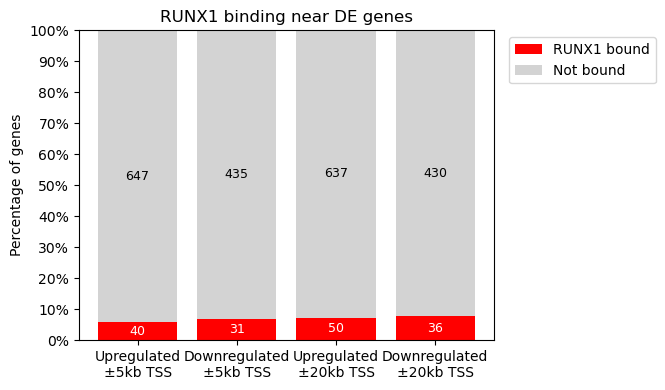

In [55]:
labels = ['Upregulated\n±5kb TSS', 'Downregulated\n±5kb TSS',
          'Upregulated\n±20kb TSS', 'Downregulated\n±20kb TSS']
bound_pct = [up_bound_5kb_pct, down_bound_5kb_pct, up_bound_20kb_pct, down_bound_20kb_pct]
unbound_pct = [up_unbound_5kb_pct, down_unbound_5kb_pct, up_unbound_20kb_pct, down_unbound_20kb_pct]
bound_cnt = [up_bound_5kb, down_bound_5kb, up_bound_20kb, down_bound_20kb]
unbound_cnt = [up_unbound_5kb, down_unbound_5kb, up_unbound_20kb, down_unbound_20kb]

fig, ax = plt.subplots(figsize=(8, 4))

# Bar plot
ax.bar(labels, bound_pct, color='red', label='RUNX1 bound')
ax.bar(labels, unbound_pct, bottom=bound_pct, color='lightgray', label='Not bound')

# Count annotations
for i in range(4):
    ax.text(i, bound_pct[i] / 2, str(bound_cnt[i]),
            ha='center', va='center', color='white', fontsize=9)
    ax.text(i, bound_pct[i] + unbound_pct[i] / 2, str(unbound_cnt[i]),
            ha='center', va='center', color='black', fontsize=9)

ax.set_ylabel('Percentage of genes')
ax.set_ylim(0, 100)
ax.set_title('RUNX1 binding near DE genes')
ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

When comparing my results to Figure 2F from the publication, I observed fewer differentially expressed (DE) genes with overlapping RUNX1 peaks in both the ±5 kb and ±20 kb TSS analyses. Specifically, the number of RUNX1-bound DE genes was noticeably lower than those reported by the authors. These discrepancies could be due to differences in peak calling thresholds, as my filtered peak set may be more conservative, or due to variability in the genome annotations or gene models used in our analyses. Combining these two analyses—focusing both near TSS and across broader gene regions—provides a more comprehensive picture of potential regulatory influence by RUNX1. This approach helps distinguish between direct promoter binding and more distal regulatory interactions, offering insights into different modes of transcriptional regulation.

# Genomic tracks for MALAT1 and NEAT1

## MALAT1

![MALAT1 IVG View](images/MALAT1.png)

## NEAT1

![NEAT1 IGV View](images/NEAT1.png)

From my annotated peaks, I observe statistically significant RUNX1 binding near both NEAT1 and MALAT1, consistent with the results shown in figures 2D and 2E of the paper. The enrichment peaks in my ChIP-seq data overlap these gene loci and are supported by clear signal in both IP replicates with minimal background in the input tracks. Visually, the genomic tracks in IGV are highly similar to those in the publication, showing distinct RUNX1 peaks upstream of each gene. Minor differences in signal intensity or peak shape may be due to replicate pooling, normalization, or visualization style used in the paper. Overall, the results validate RUNX1 binding at both genes using my reproducible peak set.

# Review supplementary results

## Figure S2A Recreation

In [32]:
data = {
    "Sample Name": ["RUNX1 ChIP 1", "RUNX1 ChIP 2", "INPUT 1", "INPUT 2"],
    "Biological Replicate": [1, 2, 1, 2],
    "Raw Reads": ["29,700,000", "30,000,000", "30,100,000", "10,900,000"],
    "Mapped Reads": ["28,100,000", "28,500,000", "28,900,000", "10,200,000"]
}

df = pd.DataFrame(data)
display(df)

,Sample Name,Biological Replicate,Raw Reads,Mapped Reads
0,RUNX1 ChIP 1,1,"29,700,000","28,100,000"
1,RUNX1 ChIP 2,2,"30,000,000","28,500,000"
2,INPUT 1,1,"30,100,000","28,900,000"
3,INPUT 2,2,"10,900,000","10,200,000"


There are clear differences between the reported raw and mapped read counts in the original publication and my own dataset. For instance, while both datasets report approximately 10.9 million raw reads for INPUT replicate 2, the mapped read count in the paper is around 7.7 million, whereas my result shows approximately 10.2 million. Additionally, my IP samples show slightly higher mapped read counts compared to those reported by the authors.

These discrepancies could be due to several factors. One likely explanation is the use of different read alignment tools or parameters—such as stricter thresholds for mapping quality or exclusion of multimapping reads—which could lead to lower reported mapping rates in the original study. Another possible reason is differences in preprocessing steps, such as adapter trimming, quality filtering, or duplicate removal, which can significantly affect how many reads are retained and subsequently mapped.

## Figure S2B

![Figure S2B](images/S2B.png)

## My correlation plot

![Spearman correlation plot](results/spearman_plot.png)

My correlation heatmap and the one presented in Supplementary Figure S2B show broadly similar clustering patterns, but with notable differences in the strength of correlation values. In the publication’s plot, Pearson correlation coefficients are high across all samples (mostly >0.69), especially within replicate types—indicating strong reproducibility and consistent signal across both INPUT and RUNX1 ChIP samples.

In my plot, generated using Spearman correlation, values are more variable and lower overall. While replicates still cluster together (e.g., IP with IP, INPUT with INPUT), the color scale reveals weaker associations, suggesting either increased variability or reduced signal similarity in your dataset. These differences may arise from using different correlation methods (Spearman vs. Pearson), normalization settings, or inclusion of noisy or low-signal regions in your bigWig summary computation.

The authors’ takeaway from Supplementary Figure S2B was that the RUNX1 ChIP-seq experiment was successful and reproducible, as evidenced by the high Pearson correlation between biological replicates and the clear clustering of ChIP versus Input samples. This strong correlation supports the reliability of their peak calls and signal profiles for downstream analysis.

In my figure, while replicates still group together, the overall correlation is weaker and more variable. Despite this, the clustering pattern is still consistent with successful separation of IP and Input conditions. Therefore, while my experiment shows some technical variability, it still supports a successful ChIP enrichment, especially since the replicates cluster appropriately and signal differences are detectable between experimental groups.

## Figure S2C Replicate

In [33]:
rep1_total = 13161
rep2_total = 17440
shared = 3349

rep1_only = rep1_total - shared
rep2_only = rep2_total - shared

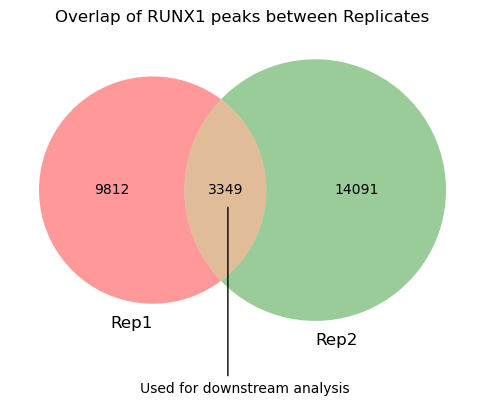

In [34]:
# Plot the Venn diagram
plt.figure(figsize=(6, 6))
venn2(subsets=(rep1_only, rep2_only, shared), set_labels=('Rep1', 'Rep2'))
plt.title("Overlap of RUNX1 peaks between Replicates")

# Add centered annotation below overlap
plt.text(0, -0.7, "Used for downstream analysis", ha='center', fontsize=10)
plt.annotate(
    '', xy=(-0.06, -0.05), xytext=(-0.06, -0.65),
    arrowprops=dict(arrowstyle='-', color='black', lw=1)
)
plt.show()

There are clear differences between my results and those presented in the publication. In my analysis, the number of unique and total peaks called in both replicates is higher than what the authors report. For instance, my Rep2 dataset shows over 14,000 unique peaks, compared to the 10,465 reported in the publication. One possible explanation for this discrepancy is the use of different peak calling parameters or software versions. The original study may have applied more stringent thresholds, used a different version of MACS3, or included additional filtering steps. Another factor could be differences in data preprocessing, such as how duplicate reads were handled, trimming protocols, or alignment stringency, all of which can significantly impact the number of peaks detected.

# Analyze the annotated peaks using Enrichr

Use overlapped genes from earlier in analysis

In [45]:
# write text file of genes for enrichment

with open("runx1_overlap_genes.txt", "w") as f:
    for gene in overlapped_genes:
        f.write(gene + "\n")

## Methodology

I used Enrichr, a web-based enrichment analysis tool, to analyze the 71 genes overlapping between my ChIP-seq peaks and differentially expressed genes. These genes were identified as being within ±5kb of the transcription start site (TSS) and meeting the significance thresholds (padj < 0.01, |log2FC| > 1). I submitted this gene list to Enrichr and selected both the ChEA 2022 transcription factor target gene set and the Reactome Pathways 2024 database. The ChEA 2022 analysis was used to assess enrichment for known transcription factor binding profiles, while the Reactome analysis provided insight into enriched biological pathways associated with these genes.

![Enrichr 1](images/enrichr1.png)

## Interpretation

The enrichment results highlight a significant overlap between the genes identified in your ChIP-seq analysis and known RUNX1 targets in MCF-7 cells, supporting the biological relevance of my experiment. The strong enrichment for RUNX1 confirms that the ChIP-seq experiment successfully captured RUNX1 binding sites associated with transcriptional regulation. Additional hits such as ESR1 and FOXM1 may suggest potential co-regulatory roles or shared regulatory networks, offering directions for future analysis into RUNX1’s function in breast cancer gene expression.

![Enrichr reactome pathways](images/enrichr2.png)

## Interpretation

The Reactome Pathways 2024 enrichment analysis of genes near RUNX1-bound peaks reveals strong associations with cell cycle regulation and DNA repair pathways. Notably, the top enriched terms include “Cell Cycle Checkpoints,” “Cell Cycle,” and “DNA Double-Strand Break Repair,” suggesting that RUNX1 may play a key role in controlling genomic integrity. These pathways are particularly relevant in the context of breast cancer, where dysregulation of cell division and DNA repair is a hallmark. This enrichment supports the hypothesis that RUNX1 directly regulates genes involved in maintaining cell cycle fidelity and preventing DNA damage accumulation. 